<center> <h1> <span style="color:black"> [BLOG POST 2]- Boost your model performance with Machine/Deep Learning</h1> </center> 
<center> <h2> <span style="color:red">Machine Learning in Actuarials  </h1> </center>
<center> <h3> <span style="color:black"> Author: Marino San Lorenzo </h1> </center>

# Agenda
* [Chapter 1 - Data Exploration](#one)
    + [1.1 univariate analysis of numerical data](#one-one)
    + [1.2 univariate analysis of categorical data](#one-two)
    + [1.3 bivariate analysis of numerical data](#one-three)
    + [1.4 bivariate analysis of categorical data](#one-four)
* [Chapter 2 - Feature Engineering](#two)
    + [2.1 Processing with Binning continuous variables](#two-one)
        + [2.1.1 Dummy Coding with reference class](#two-one-one)

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from src.constants import Constants, params, Constants2, params_blog_2, params_blog_3, ConstantsBlog3
from typing import *
from src.styling import *
from src.utils import *
from src.plots import *
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
import warnings
from sklearn.model_selection import train_test_split
from matplotlib import cm
import plotly.graph_objects as go

In [2]:
warnings.filterwarnings("ignore")
pd.set_option('display.max_colwidth', 1000)
pd.set_option('display.float_format','{:,.4f}'.format)
plt.style.use('ggplot')
pd.set_option("display.precision", 4)

In [3]:
TEST_SIZE, VAL_SIZE, RANDOM_STATE = params_blog_2.get(Constants2.TEST_SIZE),params_blog_2.get(Constants2.VAL_SIZE_FROM_TRAIN_SIZE),\
    params_blog_2.get(Constants2.RANDOM_STATE)
nb_claims_name, claim_amount_name = params_blog_2.get(Constants2.NB_CLAIMS), params_blog_2.get(Constants2.CLAIM_AMOUNT)
claim_frequency_name = params_blog_2.get(Constants2.CLAIM_FREQUENCY)
exposure_name = params_blog_2.get(Constants2.EXPOSURE_NAME)
N_ITER_SKLEARN_HYPEROPT = params_blog_2.get(Constants2.N_ITER_SKLEARN_HYPEROPT)
N_ITER= N_ITER_SKLEARN_HYPEROPT
NB_MAX_ERRORS_FOR_RERUNNING_OPTIMIZATION = 10

In [4]:
df_freq = pd.read_csv(os.path.join(params_blog_2.get(Constants2.PATH_TO_DATA), 'freMTPLfreq.csv'))
df_sev = pd.read_csv(os.path.join(params_blog_2.get(Constants2.PATH_TO_DATA), 'freMTPLsev.csv'))

In [5]:
df_freq.head(2)

,PolicyID,ClaimNb,Exposure,Power,CarAge,DriverAge,Brand,Gas,Region,Density
0,1,0,0.0900,g,0,46,Japanese (except Nissan) or Korean,Diesel,Aquitaine,76
1,2,0,0.8400,g,0,46,Japanese (except Nissan) or Korean,Diesel,Aquitaine,76


In [6]:
df_sev.head(2)

,PolicyID,ClaimAmount
0,63987,1172
1,310037,1905


In [7]:
# here we need to merge the claim amounts 

In [8]:
policy_id_of_policies_with_claims_amount = df_sev.PolicyID.to_list()

In [9]:
policy_id_of_policies_without_claims_amount = set(df_freq.PolicyID) - set(policy_id_of_policies_with_claims_amount)

In [10]:
df_sev_extension_without_claims = pd.DataFrame()
df_sev_extension_without_claims['PolicyID'] = list(policy_id_of_policies_without_claims_amount)
df_sev_extension_without_claims[claim_amount_name] = 0

In [11]:
df_sev_extended = pd.concat([df_sev, df_sev_extension_without_claims], axis=0)

In [12]:
df_sev_agg = pd.DataFrame(df_sev_extended.groupby('PolicyID')['ClaimAmount'].sum())
df_sev_agg.reset_index(drop=False)

,PolicyID,ClaimAmount
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
...,...,...
413164,413165,0
413165,413166,0
413166,413167,0
413167,413168,0


In [13]:
df = pd.merge(df_freq, df_sev_agg, how='left', on='PolicyID')

df[claim_frequency_name] = df[nb_claims_name]/df[exposure_name]

# 1. Data Exploration <a name="one"></a>

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 413169 entries, 0 to 413168
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   PolicyID         413169 non-null  int64  
 1   ClaimNb          413169 non-null  int64  
 2   Exposure         413169 non-null  float64
 3   Power            413169 non-null  object 
 4   CarAge           413169 non-null  int64  
 5   DriverAge        413169 non-null  int64  
 6   Brand            413169 non-null  object 
 7   Gas              413169 non-null  object 
 8   Region           413169 non-null  object 
 9   Density          413169 non-null  int64  
 10  ClaimAmount      413169 non-null  int64  
 11  claim_frequency  413169 non-null  float64
dtypes: float64(2), int64(6), object(4)
memory usage: 41.0+ MB


In [15]:
summary = df.describe()
summary.style.applymap(highlight_col, subset=pd.IndexSlice[['mean', 'max'], [params.get(Constants.NB_CLAIMS)]])
summary

,PolicyID,ClaimNb,Exposure,CarAge,DriverAge,Density,ClaimAmount,claim_frequency
count,"413,169.0000","413,169.0000","413,169.0000","413,169.0000","413,169.0000","413,169.0000","413,169.0000","413,169.0000"
mean,"206,585.0000",0.0392,0.5611,7.5324,45.3199,"1,985.1539",83.4164,0.1188
std,"119,271.7610",0.2041,0.3695,5.7630,14.3281,"4,776.2545","4,192.5257",2.1552
min,1.0000,0.0000,0.0027,0.0000,18.0000,2.0000,0.0000,0.0000
25%,"103,293.0000",0.0000,0.2000,3.0000,34.0000,67.0000,0.0000,0.0000
50%,"206,585.0000",0.0000,0.5400,7.0000,44.0000,287.0000,0.0000,0.0000
75%,"309,877.0000",0.0000,1.0000,12.0000,54.0000,"1,410.0000",0.0000,0.0000
max,"413,169.0000",4.0000,1.9900,100.0000,99.0000,"27,000.0000","2,036,833.0000",365.0000


In [16]:
pd.cut(df[claim_amount_name], bins= [0, 50_000, 100_000, 500_000]).value_counts()

(0, 50000]          15331
(50000, 100000]        35
(100000, 500000]       22
Name: ClaimAmount, dtype: int64

In [17]:
df[[exposure_name, nb_claims_name, claim_amount_name]].describe()

,Exposure,ClaimNb,ClaimAmount
count,"413,169.0000","413,169.0000","413,169.0000"
mean,0.5611,0.0392,83.4164
std,0.3695,0.2041,"4,192.5257"
min,0.0027,0.0000,0.0000
25%,0.2000,0.0000,0.0000
50%,0.5400,0.0000,0.0000
75%,1.0000,0.0000,0.0000
max,1.9900,4.0000,"2,036,833.0000"


In [18]:
# check how many categories for categorical variables
info_categories = get_distribution_info_for_categorical_variables(df)
info_categories

,nb_unique_categories,distribution
Power,12,"{'f': '23.17%', 'g': '22.07%', 'e': '18.64%', 'd': '16.46%', 'h': '6.46%', 'j': '4.37%', 'i': '4.26%', 'k': '2.31%', 'l': '1.13%', 'm': '0.44%', 'o': '0.36%', 'n': '0.32%'}"
Brand,7,"{'Renault, Nissan or Citroen': '52.81%', 'Japanese (except Nissan) or Korean': '19.14%', 'Opel, General Motors or Ford': '9.05%', 'Volkswagen, Audi, Skoda or Seat': '7.90%', 'Mercedes, Chrysler or BMW': '4.67%', 'Fiat': '4.05%', 'other': '2.39%'}"
Gas,2,"{'Regular': '50.15%', 'Diesel': '49.85%'}"
Region,10,"{'Centre': '38.87%', 'Ile-de-France': '16.89%', 'Bretagne': '10.19%', 'Pays-de-la-Loire': '9.38%', 'Aquitaine': '7.58%', 'Nord-Pas-de-Calais': '6.60%', 'Poitou-Charentes': '4.61%', 'Basse-Normandie': '2.64%', 'Haute-Normandie': '2.13%', 'Limousin': '1.11%'}"


## 1.1 univariate analysis of numerical data <a name="one-one"></a>

In [19]:
numerical_variables = list(df.select_dtypes(exclude=['object']).columns)
numerical_variables

['PolicyID',
 'ClaimNb',
 'Exposure',
 'CarAge',
 'DriverAge',
 'Density',
 'ClaimAmount',
 'claim_frequency']

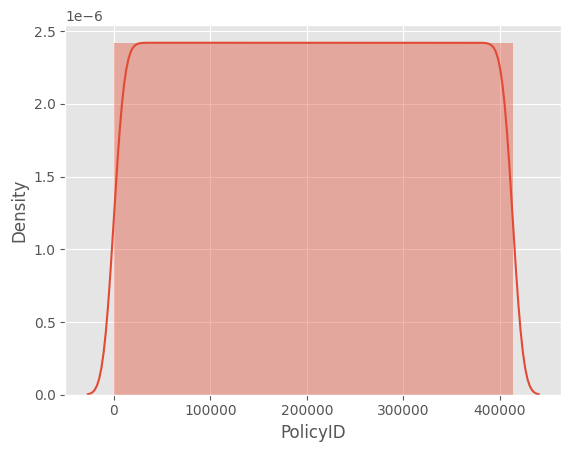

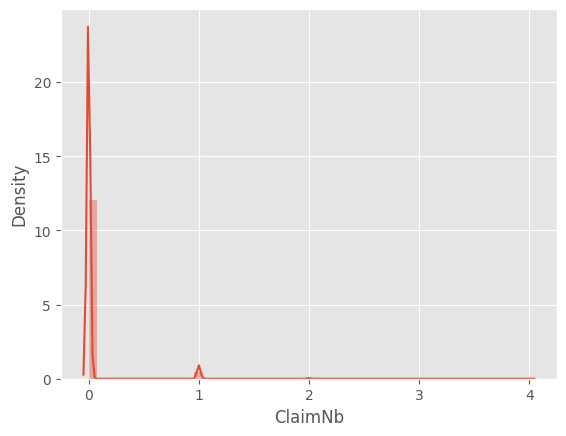

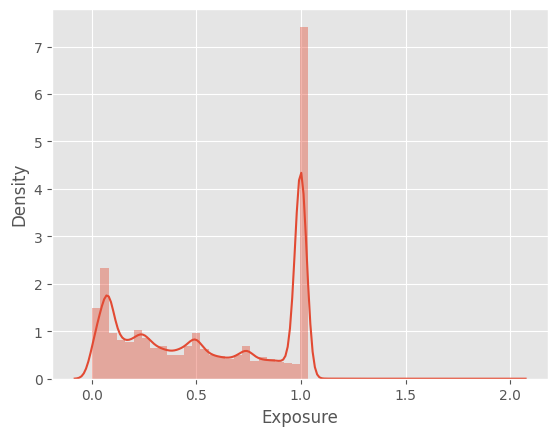

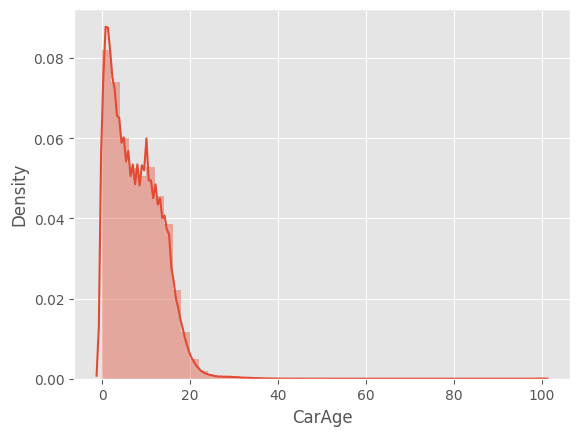

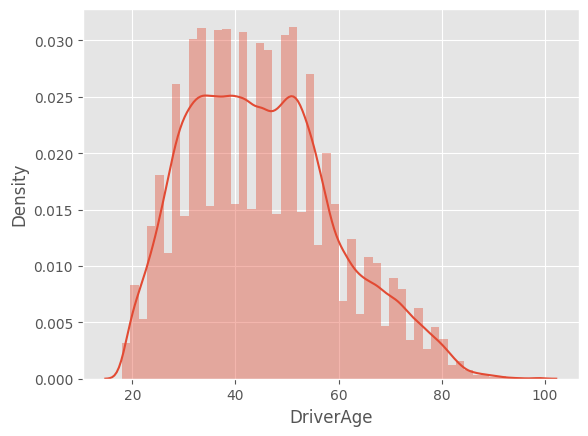

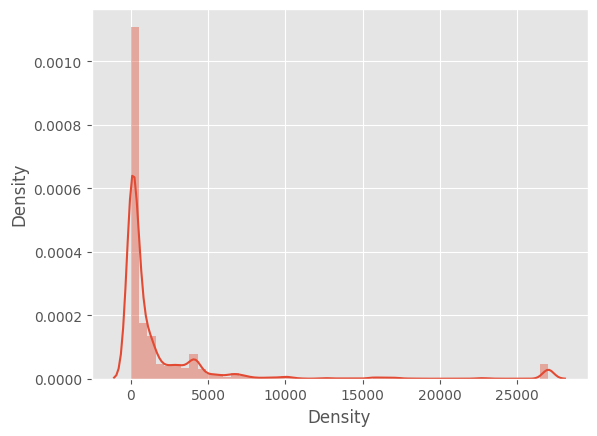

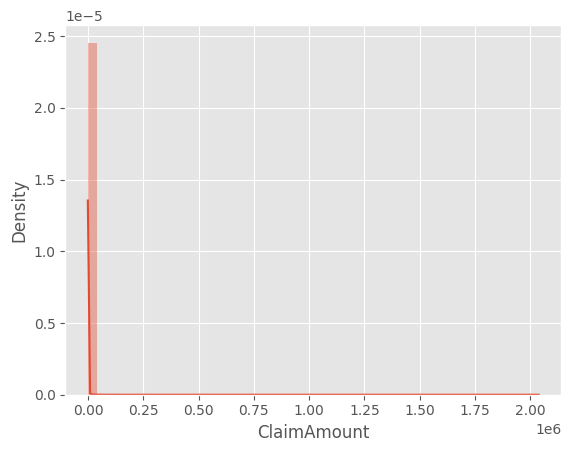

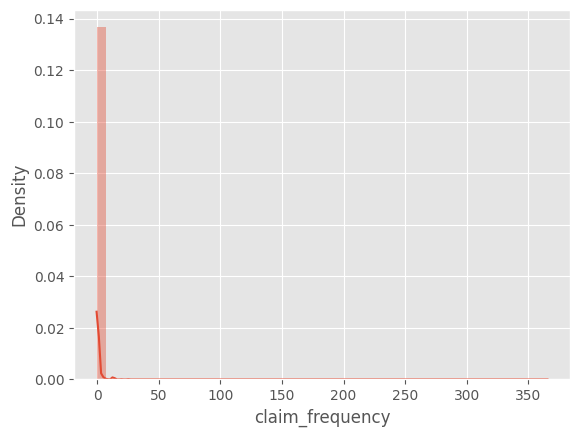

In [20]:
plot_univariate_numerical_variables_distribution(df, numerical_variables, params)

In [21]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,PolicyID,ClaimNb,Exposure,CarAge,DriverAge,Density,ClaimAmount,claim_frequency
PolicyID,1.000000,-0.034709,-0.132262,-0.078895,0.048708,0.102285,-0.005414,-0.006713
ClaimNb,-0.034709,1.000000,0.076039,0.004506,-0.006128,0.005163,0.107303,0.282522
Exposure,-0.132262,0.076039,1.000000,0.140104,0.194260,-0.112349,0.002238,-0.034530
CarAge,-0.078895,0.004506,0.140104,1.000000,-0.046414,-0.142318,0.001642,0.005092
DriverAge,0.048708,-0.006128,0.194260,-0.046414,1.000000,-0.001692,-0.004549,-0.015203
Density,0.102285,0.005163,-0.112349,-0.142318,-0.001692,1.000000,-0.001321,0.001829
ClaimAmount,-0.005414,0.107303,0.002238,0.001642,-0.004549,-0.001321,1.000000,0.044436
claim_frequency,-0.006713,0.282522,-0.034530,0.005092,-0.015203,0.001829,0.044436,1.000000


## 1.2 univariate analysis of categorical data <a name="one-two"></a>

In [22]:
categorical_variables = list(df.select_dtypes(include=['object']).columns)
categorical_variables

['Power', 'Brand', 'Gas', 'Region']

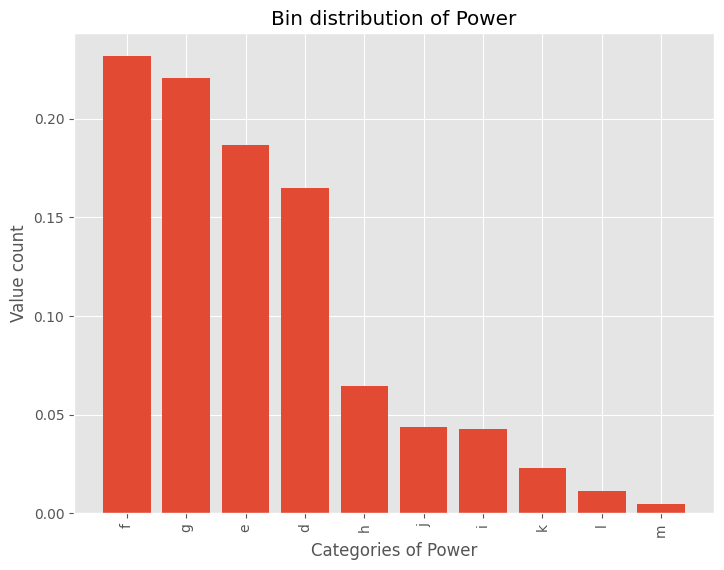

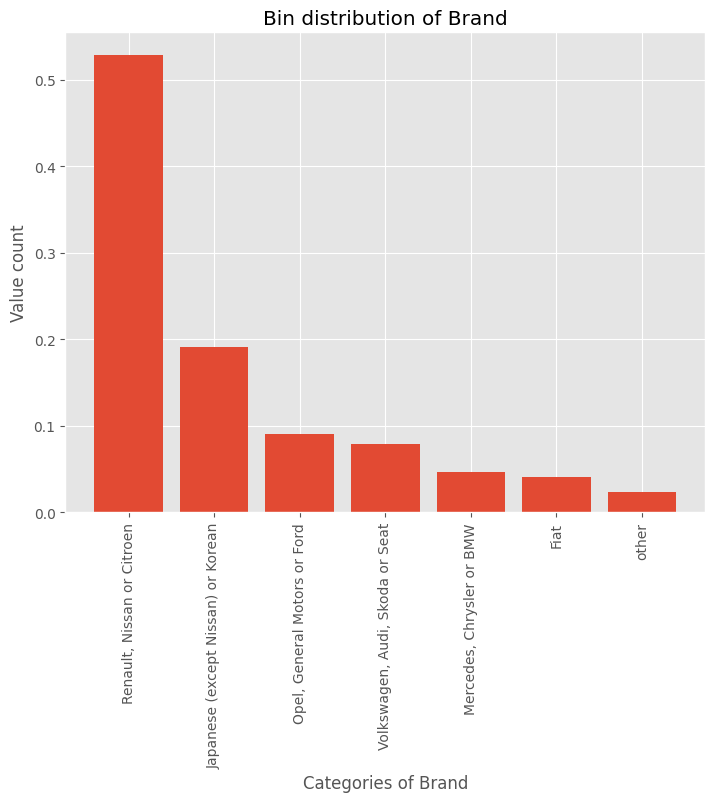

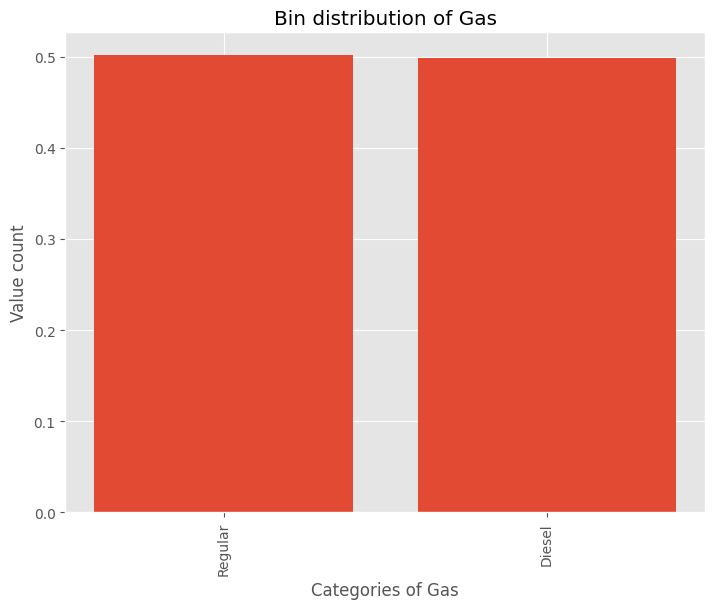

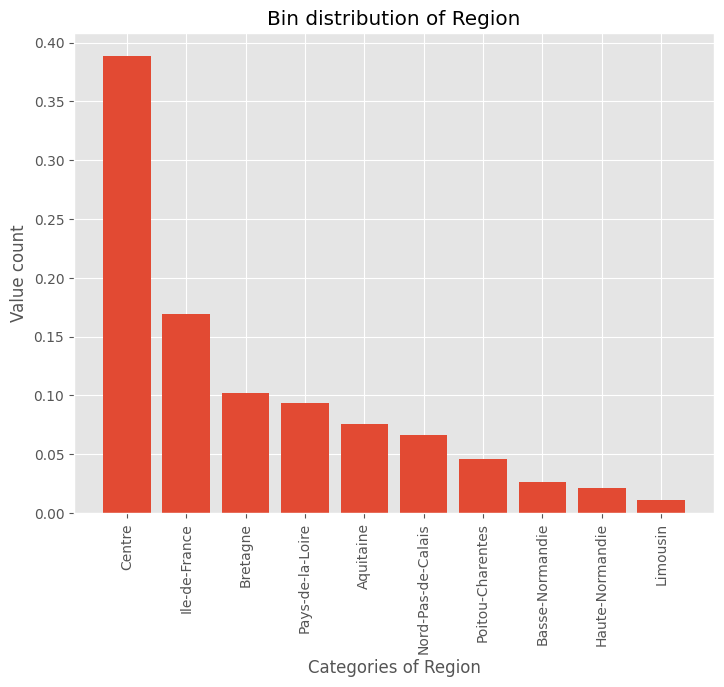

In [23]:
plot_univariate_categorical_variables_distribution(df, categorical_variables, params)

## 1.3 bivariate analysis of numerical data <a name="one-three"></a>

In [24]:
df[claim_frequency_name] = df[nb_claims_name]/df[exposure_name]

df[[claim_frequency_name, exposure_name, nb_claims_name, claim_amount_name]].describe()

,claim_frequency,Exposure,ClaimNb,ClaimAmount
count,"413,169.0000","413,169.0000","413,169.0000","413,169.0000"
mean,0.1188,0.5611,0.0392,83.4164
std,2.1552,0.3695,0.2041,"4,192.5257"
min,0.0000,0.0027,0.0000,0.0000
25%,0.0000,0.2000,0.0000,0.0000
50%,0.0000,0.5400,0.0000,0.0000
75%,0.0000,1.0000,0.0000,0.0000
max,365.0000,1.9900,4.0000,"2,036,833.0000"


In [25]:
weighted_claim_frequency = df.groupby(nb_claims_name)[nb_claims_name, exposure_name, claim_frequency_name].agg(nb_claims=(nb_claims_name, 'count'),\
                                                                                    exposure=(exposure_name, 'sum'),
                                                                                    sum_claims=(nb_claims_name, 'sum'))
weighted_claim_frequency['weighted_mean_frequency'] = weighted_claim_frequency['sum_claims']/weighted_claim_frequency['exposure']
weighted_claim_frequency

,nb_claims,exposure,sum_claims,weighted_mean_frequency
ClaimNb,,,,
0,397779,"220,936.4198",0,0.0000
1,14633,"10,348.4442",14633,1.4140
2,726,519.7037,1452,2.7939
3,28,18.6700,84,4.4992
4,3,0.9300,12,12.9032


In [26]:
feature = 'DriverAge'
binned_feature = f'{feature}_binned'
df_cp = df.copy()
df_cp[binned_feature] = pd.qcut(df[feature], q=10, precision=0, duplicates="drop")
weighted_claim_freq = df_cp.groupby(binned_feature).agg(sum_claims=(nb_claims_name, 'sum'), exposure = (exposure_name, 'sum'))

In [27]:
weighted_claim_freq['weighted_claim_frequency'] = weighted_claim_freq['sum_claims']/weighted_claim_freq['exposure']

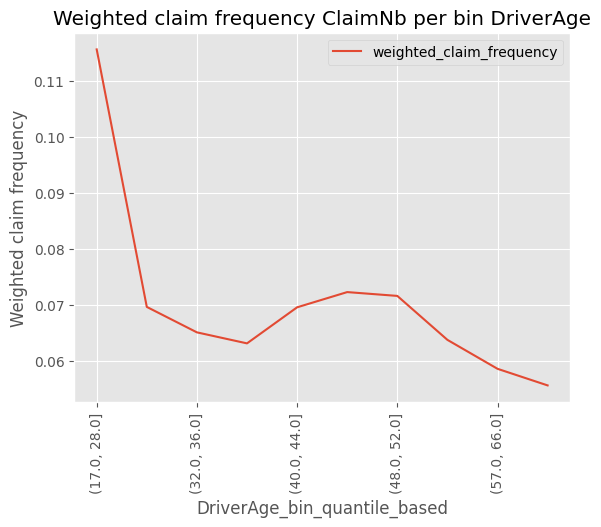

In [28]:
plot_avg_target_per_numerical_bin(df, ['DriverAge'], params_blog_2, target=nb_claims_name,exposure_name=exposure_name)

**Some observations:**

- The variable `DriverAge` is almost monotonically decreasing, we observe a small bump between 40 and 52 yo.

## 1.4 bivariate analysis of categorical data <a name="one-four"></a>

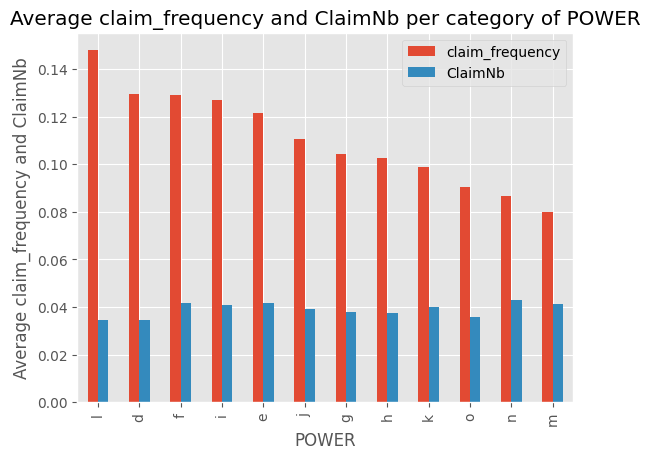

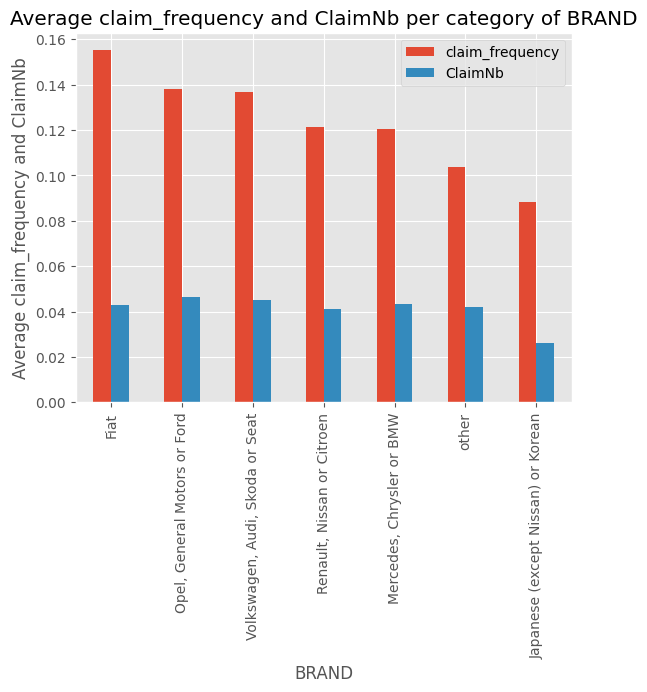

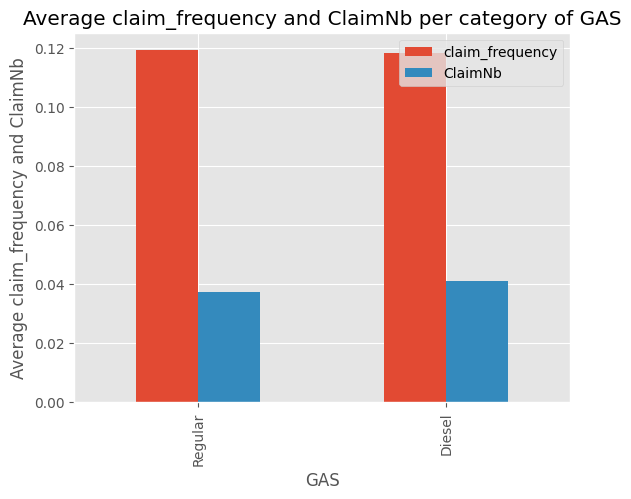

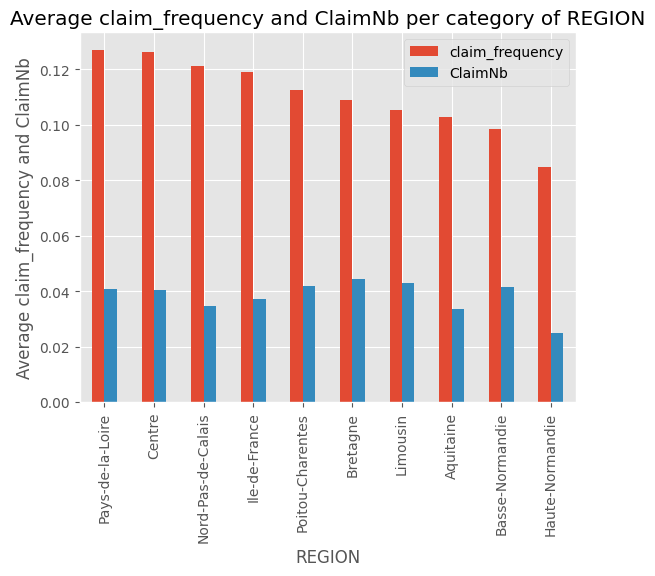

In [29]:
plt_avg_target_per_category(df, categorical_variables, params_blog_2, target=claim_frequency_name)

**TOCHANGE!!Some observations:**

- Difficult to interpret anything based on the `CODPOSS`, later on we will try to map this data to district information 
- `AGECAR`: it looks like it has a slight monotonic decreasing relationship between the claim frequency and `AGECAR`
- `SEXP_female` is slightly riskier group than `SEXP_male` when took alone.
- `FUELC_petrol` is slightly less risky group than `FUELC_gasoil` when took alone.
- `SPLIT`: Policyholders who pay their coverage by Thrice are riskier tham the Once.
- `USEC`: Professional and Private use do not seem to be significantly different.
- `FLEETC`: The fleet group is less risky.
- `SPORTC`: The sport group is riskier.
- `COVERP`: difficult to draw any conclusions.
- `POWERC`: It looks like the more power, the riskier although it is not absolutely clear.

In [30]:
for cat_var in categorical_variables:
    print(df.groupby(cat_var)[[claim_frequency_name,nb_claims_name, claim_amount_name]].mean().sort_values(by=[nb_claims_name, claim_amount_name], ascending=False))
    print('-'*100)

       claim_frequency  ClaimNb  ClaimAmount
Power                                       
n               0.0868   0.0428      75.4491
f               0.1293   0.0418     100.2895
e               0.1217   0.0416      72.4898
m               0.0802   0.0415     109.2877
i               0.1271   0.0410     185.6694
k               0.0989   0.0398      75.5235
j               0.1104   0.0394      76.1778
g               0.1042   0.0380      77.2182
h               0.1028   0.0375      64.9362
o               0.0904   0.0358      50.3800
d               0.1297   0.0347      65.7784
l               0.1479   0.0346      62.5238
----------------------------------------------------------------------------------------------------
                                    claim_frequency  ClaimNb  ClaimAmount
Brand                                                                    
Opel, General Motors or Ford                 0.1383   0.0463      79.4561
Volkswagen, Audi, Skoda or Seat              0.

# 2. Feature Engineering <a name="two"></a>

We decide to work only with categorical variables in order for faciliate the interpretation. 

In [31]:
for cat_var in categorical_variables:
    df[cat_var] = pd.Categorical(df[cat_var])
for num_var in numerical_variables:
    df[num_var] = pd.to_numeric(df[num_var])

In order for our algorithm/model to correctly read the information we feed it, the data needs to be numerically encoded. To keep things simple, suppose we had a vector of the age of policyholder as follow with minimum and maximum age going from 0 to 100:

age = (90, 20, 30, 60, 79)

We apply quantile binning method such that such vector will be transformed in such a matrice:


In [32]:
age_transformed = pd.DataFrame.from_dict({'[0-20)':[0,0,0,0,0],
                                          '[20-40)':[0, 1, 1, 0,0],
                                        '[40-60)':[0,0,0,0,0],
                                        '[60-80)':[0,0,0,1,1],
                                        '[80-100]':[1,0,0,0,0]})

In [33]:
age_transformed.index = [90, 20, 30, 60, 79]

age_transformed

,[0-20),[20-40),[40-60),[60-80),[80-100]
90,0,0,0,0,1
20,0,1,0,0,0
30,0,1,0,0,0
60,0,0,0,1,0
79,0,0,0,1,0


In [34]:
df.dtypes

PolicyID              int64
ClaimNb               int64
Exposure            float64
Power              category
CarAge                int64
DriverAge             int64
Brand              category
Gas                category
Region             category
Density               int64
ClaimAmount           int64
claim_frequency     float64
dtype: object

In [35]:
numerical_variables_to_bin = ['DriverAge', 'CarAge', 'Density']
for numerical_var in numerical_variables_to_bin:
    df = bin_numerical_variables(df, numerical_var, nb_bin=5)

In [36]:
df.head(2)

,PolicyID,ClaimNb,Exposure,Power,CarAge,DriverAge,Brand,Gas,Region,Density,ClaimAmount,claim_frequency,DriverAge_bin,CarAge_bin,Density_bin
0,1,0,0.0900,g,0,46,Japanese (except Nissan) or Korean,Diesel,Aquitaine,76,0,0.0000,"(40.0, 48.0]","(-0.001, 2.0]","(51.0, 158.0]"
1,2,0,0.8400,g,0,46,Japanese (except Nissan) or Korean,Diesel,Aquitaine,76,0,0.0000,"(40.0, 48.0]","(-0.001, 2.0]","(51.0, 158.0]"


In [37]:
df.CarAge_bin.replace({'(-0.001, 2.0]':'(0.0, 2.0]'}, inplace=True)
df.head(2).transpose()

,0,1
PolicyID,1,2
ClaimNb,0,0
Exposure,0.0900,0.8400
Power,g,g
CarAge,0,0
DriverAge,46,46
Brand,Japanese (except Nissan) or Korean,Japanese (except Nissan) or Korean
Gas,Diesel,Diesel
Region,Aquitaine,Aquitaine
Density,76,76


In [38]:
df.dtypes

PolicyID              int64
ClaimNb               int64
Exposure            float64
Power              category
CarAge                int64
DriverAge             int64
Brand              category
Gas                category
Region             category
Density               int64
ClaimAmount           int64
claim_frequency     float64
DriverAge_bin      category
CarAge_bin         category
Density_bin        category
dtype: object

## 2.1 Processing with Binning continuous variables <a name="two-one"></a>

In [39]:
TEST_SIZE, RANDOM_STATE = params.get(Constants.TEST_SIZE), params.get(Constants.RANDOM_STATE)

In [40]:
df_cp = df.copy()

In [41]:
df.columns

Index(['PolicyID', 'ClaimNb', 'Exposure', 'Power', 'CarAge', 'DriverAge',
       'Brand', 'Gas', 'Region', 'Density', 'ClaimAmount', 'claim_frequency',
       'DriverAge_bin', 'CarAge_bin', 'Density_bin'],
      dtype='object')

In [42]:
non_predictor_variables = [*numerical_variables_to_bin,
                        *params_blog_2.get(Constants2.VARIABLES_TO_EXCLUDE)]

In [43]:
df_step1 =df.drop(columns=non_predictor_variables)

In [44]:
df_step1.columns

Index(['ClaimNb', 'Exposure', 'Power', 'Brand', 'Gas', 'Region', 'ClaimAmount',
       'claim_frequency', 'DriverAge_bin', 'CarAge_bin', 'Density_bin'],
      dtype='object')

In [45]:
df_step1.dtypes

ClaimNb               int64
Exposure            float64
Power              category
Brand              category
Gas                category
Region             category
ClaimAmount           int64
claim_frequency     float64
DriverAge_bin      category
CarAge_bin         category
Density_bin        category
dtype: object

In [46]:
get_distribution_info_for_categorical_variables(df_step1)

,nb_unique_categories,distribution
Power,12,"{'f': '23.17%', 'g': '22.07%', 'e': '18.64%', 'd': '16.46%', 'h': '6.46%', 'j': '4.37%', 'i': '4.26%', 'k': '2.31%', 'l': '1.13%', 'm': '0.44%', 'o': '0.36%', 'n': '0.32%'}"
Brand,7,"{'Renault, Nissan or Citroen': '52.81%', 'Japanese (except Nissan) or Korean': '19.14%', 'Opel, General Motors or Ford': '9.05%', 'Volkswagen, Audi, Skoda or Seat': '7.90%', 'Mercedes, Chrysler or BMW': '4.67%', 'Fiat': '4.05%', 'other': '2.39%'}"
Gas,2,"{'Regular': '50.15%', 'Diesel': '49.85%'}"
Region,10,"{'Centre': '38.87%', 'Ile-de-France': '16.89%', 'Bretagne': '10.19%', 'Pays-de-la-Loire': '9.38%', 'Aquitaine': '7.58%', 'Nord-Pas-de-Calais': '6.60%', 'Poitou-Charentes': '4.61%', 'Basse-Normandie': '2.64%', 'Haute-Normandie': '2.13%', 'Limousin': '1.11%'}"
DriverAge_bin,5,"{'(17.999, 32.0]': '21.08%', '(48.0, 57.0]': '20.42%', '(32.0, 40.0]': '20.07%', '(40.0, 48.0]': '19.34%', '(57.0, 99.0]': '19.10%'}"
CarAge_bin,5,"{'(0.0, 2.0]': '24.29%', '(5.0, 9.0]': '20.63%', '(9.0, 13.0]': '19.65%', '(2.0, 5.0]': '18.94%', '(13.0, 100.0]': '16.49%'}"
Density_bin,5,"{'(1.999, 51.0]': '20.17%', '(158.0, 555.0]': '20.00%', '(2404.0, 27000.0]': '20.00%', '(555.0, 2404.0]': '20.00%', '(51.0, 158.0]': '19.83%'}"


### 2.1.1 Dummy Coding with reference class <a name="two-one-one"></a>

One-hot encoding works as follow suppose you have a vector of information as follow

genders = (Male, Female, Female, Female, Male)

Now, suppose the male group is less risky (like this is the case in this dataset, in terms of average claim frequency), we will decide to take out the gender_male variable from the dataset as it constitutes a reference class. 

We will end up with a transformation of our gender vector as follow:


In [47]:
genders_transformed = pd.DataFrame.from_dict({'gender_male':[1, 0,0,0,1],
                                              'gender_female':[0,1,1,1,0],
                                             })
genders_transformed.index=['Male', 'Female', 'Female', 'Female', 'Male']

In [48]:
pd.DataFrame(genders_transformed.loc[:, 'gender_female'])

,gender_female
Male,0
Female,1
Female,1
Female,1
Male,0


In [49]:
df_step1_dummy = pd.get_dummies(df_step1)

In [50]:
reference_class_lst = get_reference_classes(df_step1, nb_claims_name, exposure_name)

The reference class of Power is m
The reference class of Brand is Japanese (except Nissan) or Korean
The reference class of Gas is Diesel
The reference class of Region is Haute-Normandie
The reference class of DriverAge_bin is (57.0, 99.0]
The reference class of CarAge_bin is (0.0, 2.0]
The reference class of Density_bin is (1.999, 51.0]


In [51]:
reference_class_sev_lst = get_reference_classes(df_step1, claim_amount_name, valid_for_severity=True)

The reference class of Power is o
The reference class of Brand is Japanese (except Nissan) or Korean
The reference class of Gas is Diesel
The reference class of Region is Haute-Normandie
The reference class of DriverAge_bin is (32.0, 40.0]
The reference class of CarAge_bin is (13.0, 100.0]
The reference class of Density_bin is (2404.0, 27000.0]


The policyholder belonging to all those classes is the less risky

As we have been encoding our variables $x_{ij}s$ as binary variables.

$\beta_{0}$ is the risk related to the reference class.

According to the Poisson regression model defined above, the annual claim frequency $\lambda_{i}$ associated with $x_{i}$ is of multiplicative form:

$\lambda_{i} = exp(\beta_{0}) \prod_{j|x_{ij}=1}exp(\beta_{j})$

-  $exp(\beta_{0})$ is the annual claim frequency associated with the reference class
- $exp(\beta_{j})$ models the impact of the jth variable

In [52]:
reference_class_lst

['Power_m',
 'Brand_Japanese (except Nissan) or Korean',
 'Gas_Diesel',
 'Region_Haute-Normandie',
 'DriverAge_bin_(57.0, 99.0]',
 'CarAge_bin_(0.0, 2.0]',
 'Density_bin_(1.999, 51.0]']

In [53]:
df_step1_dummy.head(2).transpose()

,0,1
ClaimNb,0.0000,0.0000
Exposure,0.0900,0.8400
ClaimAmount,0.0000,0.0000
claim_frequency,0.0000,0.0000
Power_d,0.0000,0.0000
Power_e,0.0000,0.0000
Power_f,0.0000,0.0000
Power_g,1.0000,1.0000
Power_h,0.0000,0.0000
Power_i,0.0000,0.0000


In [54]:
DATASET = df_step1_dummy.drop(columns=reference_class_lst)
DATASET_SEV = df_step1_dummy.drop(columns=reference_class_sev_lst)
DATASET.shape == (df_step1_dummy.shape[0], df_step1_dummy.shape[1] -len(reference_class_lst))

True

In [55]:
DATASET.rename(columns=params_blog_2.get(Constants2.RENAMING_DUMMY_CODING_MAPPING), inplace=True)
DATASET_SEV.rename(columns=params_blog_2.get(Constants2.RENAMING_DUMMY_CODING_MAPPING), inplace=True)

In [56]:
DATASET.head(2).transpose()

,0,1
ClaimNb,0.0000,0.0000
Exposure,0.0900,0.8400
ClaimAmount,0.0000,0.0000
claim_frequency,0.0000,0.0000
power_d,0.0000,0.0000
power_e,0.0000,0.0000
power_f,0.0000,0.0000
power_g,1.0000,1.0000
power_h,0.0000,0.0000
power_i,0.0000,0.0000


In [57]:
path_to_data = params_blog_2.get(Constants2.PATH_TO_DATA)
path_to_dataset_freq = os.path.join(path_to_data, params_blog_2.get(Constants2.DATASET_FREQ_NAME))
path_to_dataset_sev = os.path.join(path_to_data, params_blog_2.get(Constants2.DATASET_SEV_NAME))

In [58]:
if not os.path.exists(path_to_dataset_freq):
    DATASET.to_pickle(path_to_dataset_freq)
if not os.path.exists(path_to_dataset_sev):
    DATASET_SEV.to_pickle(path_to_dataset_sev)

In [59]:
claim_frequency, claim_amount = DATASET[claim_frequency_name], DATASET[claim_amount_name]
X = DATASET.drop(columns=[claim_frequency_name, claim_amount_name])
X_sev = DATASET_SEV.drop(columns=[claim_frequency_name, nb_claims_name])

In [60]:
## let's plot the exposure with respect to the numerical variables

In [61]:
binned_variables = [c for c in df.columns if '_bin' in c]
binned_variables

['DriverAge_bin', 'CarAge_bin', 'Density_bin']

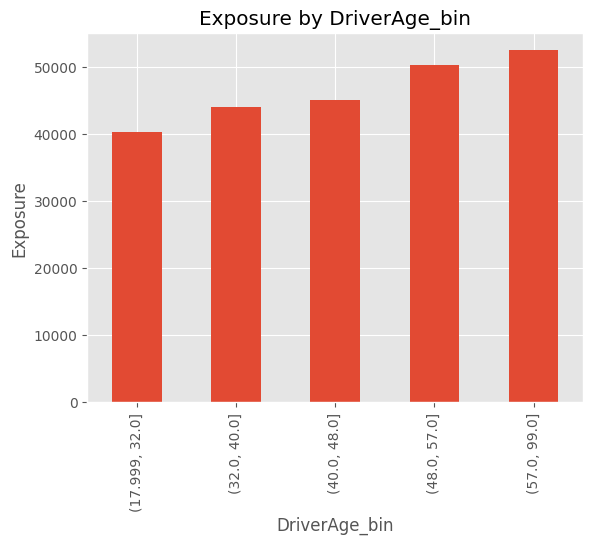

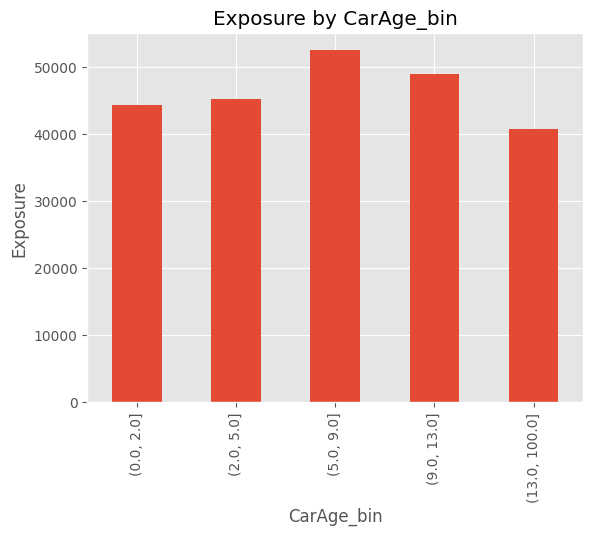

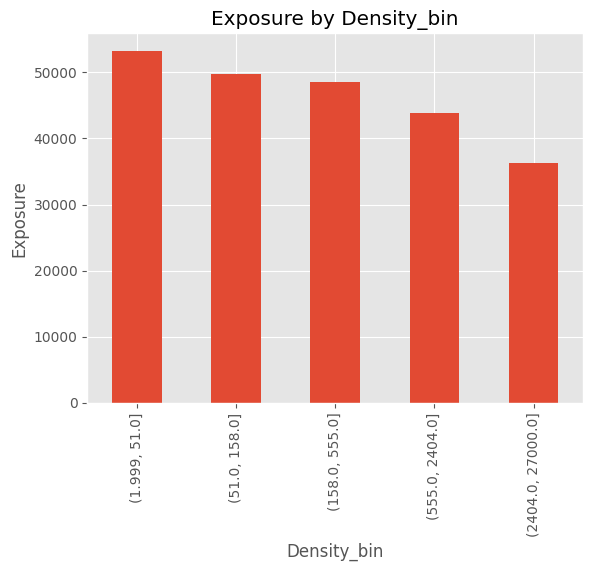

In [62]:
for binned_variable in binned_variables:
    df.groupby(binned_variable).sum()[exposure_name].plot.bar()
    plt.ylabel(exposure_name)
    plt.title(f'{exposure_name} by {binned_variable}')
    plt.show()